## Infection Path Analysis Using Routes

The purpose of this notebook is to try and analyse the path of infection for COVID-19. Below is a brief description of how the algorithm works.

### Path of Infection Algorithm

1. Pick a sufficiently large threshold (infected_thresh) which indicates when a location has been infected.
2. Using time series data, add the location that first recorded infections (even if it is below the threshold).
3. If a location becomes infected and has a direct path to another location that is infected then add an edge. If it does not have a direct path to another infected location then decrease infected_thresh and go back to step 2.
4. Repeat step 3 for all the time series data. If all infected locations are added and the rule defined in step 3 is never broken and the graph contains x% of the countries that have recorded COVID-19 

In [1]:
from covid_data import CovidData
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import time

In [2]:
from ipyleaflet import (
    Map, basemaps, basemap_to_tiles, Circle, 
    Marker, FullScreenControl, LayersControl, 
    LayerGroup, CircleMarker, Polyline, WidgetControl
)

from ipywidgets import HTML

In [20]:
covid_data_manager = CovidData()

bin_region_column = 'state'
covid_data, routes_data = covid_data_manager.getData(bin_region_column=bin_region_column)
data_confirmed = covid_data['confirmed']
border_closures = covid_data_manager.loadBorderDataset()
data_confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20
0,Alabama,US,32.884280,-86.710122,0,0,0,0,0,0,...,11101,11373,11674,11771,12086,12376,13052,13288,13670,14117.0
1,Alaska,US,60.261375,-145.838598,0,0,0,0,0,0,...,379,387,387,387,387,399,401,401,403,407.0
2,Alberta,Canada,53.933300,-116.576500,0,0,0,0,0,0,...,6457,6515,6587,6644,6683,6716,6735,6768,6800,6818.0
3,American Samoa,US,-14.271000,-170.132000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,Anguilla,United Kingdom,18.220600,-63.068600,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,none,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,375,375,376,381,388,391,398,423,423,423.0
317,none,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6.0
318,none,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,85,106,122,128,130,167,184,197,209,212.0
319,none,Zambia,-15.416700,28.283300,0,0,0,0,0,0,...,654,654,679,753,761,772,832,866,920,920.0


In [4]:
def clean_data(data_confirmed):
    return data_confirmed.loc[(data_confirmed['Lat'] != 0) & (data_confirmed['Long'] != 0)]

def clean_routes(routes, bin_region_column):
    if bin_region_column == 'county':
        return routes.loc[~((routes['DepartCounty'] == routes['ArrivalCounty']) &
                            (routes['DepartProvince/State'] == routes['ArrivalProvince/State']) &
                            (routes['DepartCountry/Region'] == routes['ArrivalCountry/Region']))]
    elif bin_region_column == 'state':
        return routes.loc[~((routes['DepartProvince/State'] == routes['ArrivalProvince/State']) &
                            (routes['DepartCountry/Region'] == routes['ArrivalCountry/Region']))]
    else:
        return routes.loc[~(routes['DepartCountry/Region'] == routes['ArrivalCountry/Region'])]
    
data_confirmed = clean_data(data_confirmed)
routes = clean_routes(routes_data, bin_region_column)

In [8]:
def get_initial_infect_thresh(data_confirmed, infect_percent):
    latest_date = data_confirmed.columns.tolist()[-1]
    num_of_countries = data_confirmed.shape[0]
    return data_confirmed.sort_values(latest_date).iloc[int(num_of_countries*(1-infect_percent))][latest_date]

def route_indexes_between_nodes(node_loc_0, node_loc_1, routes, bin_region_column):
        node_loc_names_0 = node_loc_0.split(':')
        node_loc_names_1 = node_loc_1.split(':')
        
        if bin_region_column == 'county':
            from_0_to_1 = ((routes['DepartCounty'] == node_loc_names_0[0]) & 
                           (routes['DepartProvince/State'] == node_loc_names_0[1]) &
                           (routes['DepartCountry/Region'] == node_loc_names_0[2]) &
                           (routes['ArrivalCounty'] == node_loc_names_1[0]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_1[1]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[2]))
            
            from_1_to_0 = ((routes['DepartCounty'] == node_loc_names_1[0]) & 
                           (routes['DepartProvince/State'] == node_loc_names_1[1]) &
                           (routes['DepartCountry/Region'] == node_loc_names_1[2]) &
                           (routes['ArrivalCounty'] == node_loc_names_0[0]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_0[1]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[2]))
        elif bin_region_column == 'state':
            from_0_to_1 = ((routes['DepartProvince/State'] == node_loc_names_0[0]) &
                           (routes['DepartCountry/Region'] == node_loc_names_0[1]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_1[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[1]))
            
            from_1_to_0 = ((routes['DepartProvince/State'] == node_loc_names_1[0]) &
                           (routes['DepartCountry/Region'] == node_loc_names_1[1]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_0[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[1]))
        else:
            from_0_to_1 = ((routes['DepartCountry/Region'] == node_loc_names_0[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[0]))
            
            from_1_to_0 = ((routes['DepartCountry/Region'] == node_loc_names_1[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[0]))
        return from_0_to_1, from_1_to_0
    
def get_cases_on_date(name_loc, data_confirmed, date, bin_region_column):
    name_loc_split = name_loc.split(':')
    if bin_region_column == 'county':
        return data_confirmed.loc[(data_confirmed['County'] == name_loc_split[0]) &
                                  (data_confirmed['Province/State'] == name_loc_split[1]) &
                                  (data_confirmed['Country/Region'] == name_loc_split[2])][date]
    elif bin_region_column == 'state':
        return data_confirmed.loc[(data_confirmed['Province/State'] == name_loc_split[0]) &
                                  (data_confirmed['Country/Region'] == name_loc_split[1])][date]
    else:
        return data_confirmed.loc[(data_confirmed['Country/Region'] == name_loc_split[0])][date]
    
def get_dates(data_confirmed, bin_region_column):
    if bin_region_column == 'county':
        return data_confirmed.columns.tolist()[5:]
    if bin_region_column == 'state':
        return data_confirmed.columns.tolist()[4:]
    if bin_region_column == 'country':
        return data_confirmed.columns.tolist()[3:]

def get_infection_path(data_confirmed, routes, infect_thresh, bin_region_column, border_closures = None):
    if not border_closures == None:
        assert bin_region_column == 'state' or bin_region_column == 'country', "Can only use border closures for state and country analysis"
    
    def get_loc_name(df_row, bin_region_column=bin_region_column):
        if bin_region_column == 'county':
            return "{}:{}:{}".format(df_row['County'], df_row['Province/State'], df_row['Country/Region'])
        elif bin_region_column == 'state':
            return "{}:{}".format(df_row['Province/State'], df_row['Country/Region'])
        elif bin_region_column == 'country':
            return "{}".format(df_row['Country/Region'])
        return None
    
    def get_initial_case(data_confirmed, dates):
        first_date = dates[0]
        return data_confirmed.sort_values(first_date).iloc[-1]
    
    def get_latest_date_index_of_lockdown(border_closures, date, dates):
        dates_list = [bc_entry['date'] for bc_entry in border_closures]
        date_index = dates.index(date)
        max_index = -1
        for test_index_bc in range(len(dates_list)):
            test_index_dates = dates.index(dates_list[test_index_bc])
            if test_index_bc > max_index and test_index_dates <= date_index: 
                max_index = test_index_bc
        return max_index
    
    def in_lock(loc1_split, border_closure, date, dates):
        if not border_closure == None:
            latest_date_index = get_latest_date_index_of_lockdown(border_closure, date, dates)
            if not latest_date_index == -1: 
                whitelist = border_closure[latest_date_index]['whitelist']
                blacklist = border_closure[latest_date_index]['blacklist']

                if len(blacklist) > 0:
                    if loc1_split[-1] in blacklist:
                        return True
                elif not loc1_split[-1] in whitelist:
                    return True
        return False
    
    def loc0_disallow_loc1(loc0, loc1, date, dates, border_closures, bin_region_column):
        
        loc0_split = loc0.split(':')
        loc1_split = loc1.split(':')
        
        if bin_region_column == 'state':
            state = loc0_split[0]
            country = loc0_split[1]
            
            if not state == 'none':
                border_closure = border_closures['state'].get("{}:{}".format(state,country), None)
                if in_lock(loc1_split, border_closure, date, dates):
                    return True
            else:
                border_closure = border_closures['country'].get(country, None)
                if in_lock(loc1_split, border_closure, date, dates):
                    return True
        else:
            country = loc0_split[0]
            border_closure = border_closures['country'].get(country, None)
            if in_lock(loc1_split, border_closure, date, dates):
                return True
        return False
    
    def check_for_lockdowns(loc0, loc1, date, dates, border_closures, bin_region_column=bin_region_column):
        if border_closures == None: return False
        
        if loc0_disallow_loc1(loc0, loc1, date, dates, border_closures, bin_region_column):
            return True
        elif loc0_disallow_loc1(loc1, loc0, date, dates, border_closures, bin_region_column):
            return True
        return False  
        
    
    infect_graph = nx.Graph()
    dates = get_dates(data_confirmed, bin_region_column)
    case_zero = get_initial_case(data_confirmed, dates)
    case_zero_name = get_loc_name(case_zero)
    infect_graph.add_node(case_zero_name)
    location_pos = {case_zero_name : (case_zero['Lat'], case_zero['Long'])}
    infect_graphs = {}
    max_confirmed = {}
    infected_parents = {case_zero_name : []}
    new_locs = {dates[0] : [case_zero_name]}
    new_edges = {}

    for date in tqdm(dates):
        if not date == dates[0]:
            new_locs[date] = []
        
        new_edges[date] = []
        
        conf_sort_day =  data_confirmed.sort_values(date).loc[data_confirmed[date] >= infect_thresh]
        try:
            max_confirmed[date] = conf_sort_day.iloc[-1][date]
        except:
            max_confirmed[date] = case_zero[date]
        
        for _index, row in conf_sort_day.iterrows():
            node_loc = get_loc_name(row)
            
            if not infect_graph.has_node(node_loc):
#                already_infected = infect_graph.nodes
                coords = (row['Lat'], row['Long'])
                infect_graph.add_node(node_loc, pos=coords)
                infected_parents[node_loc] = []
                location_pos[node_loc] = coords
                new_locs[date] = new_locs[date] + [node_loc]
                
#                 for infected in already_infected:
#                     from_infected_to_loc, from_loc_to_infected = route_indexes_between_nodes(infected, node_loc, routes, bin_region_column)
                    
#                     if routes.loc[from_infected_to_loc].shape[0] > 0 or routes.loc[from_loc_to_infected].shape[0] > 0:
#                         if not check_for_lockdowns(node_loc, infected, date, dates, border_closures, bin_region_column):
#                             infect_graph.add_edge(infected, node_loc)
#                             new_edges[date] = new_edges[date] + [(infected, node_loc)]
#                             infected_parents[infected] = infected_parents[infected] + [node_loc]
                
        already_infected = infect_graph.nodes
        for node_loc in new_locs[date]:
            for infected in already_infected:
                if node_loc == infected: continue
                from_infected_to_loc, from_loc_to_infected = route_indexes_between_nodes(infected, 
                                                                                         node_loc, 
                                                                                         routes, bin_region_column)

                if routes.loc[from_infected_to_loc].shape[0] > 0 or routes.loc[from_loc_to_infected].shape[0] > 0:
                    if not check_for_lockdowns(node_loc, 
                                               infected, 
                                               date, 
                                               dates, 
                                               border_closures):
                        infect_graph.add_edge(infected, node_loc)
                        new_edges[date] = new_edges[date] + [(infected, node_loc)]
                        infected_parents[infected] = infected_parents[infected] + [node_loc]
        
        confirmed_cases_attributes = { get_loc_name(row): row[date] for _index, row in conf_sort_day.iterrows()}
        nx.set_node_attributes(infect_graph, confirmed_cases_attributes, 'confirmed')
        infect_graphs[date] = infect_graph.copy()
        
    return infect_graphs, location_pos, max_confirmed, infected_parents, new_locs, new_edges

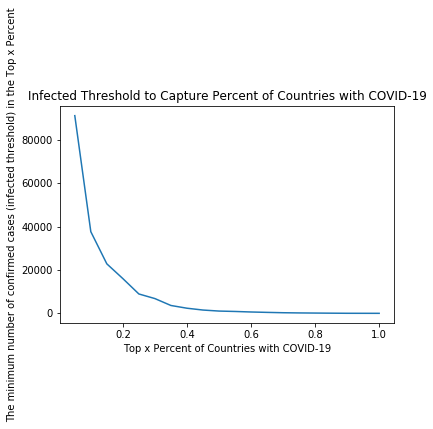

In [6]:
plt.plot([xx for xx in np.arange(0.05, 1.05, 0.05)], 
         [ get_initial_infect_thresh(data_confirmed, xx) for xx in np.arange(0.05, 1.05, 0.05)])
plt.title("Infected Threshold to Capture Percent of Countries with COVID-19")
plt.xlabel("Top x Percent of Countries with COVID-19")
plt.ylabel("The minimum number of confirmed cases (infected threshold) in the Top x Percent")
plt.show()

In [9]:
infect_thresh = get_initial_infect_thresh(data_confirmed, 1.0)
if infect_thresh <= 0: infect_thresh = 1
print("INITIAL INFECTION THRESHOLD SET TO {}".format(infect_thresh))
infect_graphs, location_pos, max_confirmed, infected_parents, new_locs, new_edges = get_infection_path(data_confirmed, 
                                                                                                       routes, 
                                                                                                       infect_thresh, 
                                                                                                       bin_region_column,
                                                                                                       border_closures=border_closures)

  0%|          | 0/123 [00:00<?, ?it/s]

INITIAL INFECTION THRESHOLD SET TO 1


100%|██████████| 123/123 [03:59<00:00,  1.95s/it]


In [15]:
class TimeMapAnimation:

    def __init__(self, infect_graphs, location_pos, data_confirmed, routes, new_locs, new_edges, bin_region_column, 
                 date_list=None, zoom=1.0, scale=3, dynamic_line_opacity=False, line_opacity=0.02, center = (0,0), 
                 date_msg_format = '<p style="color:red">Date: <b>{date}</b></p>', verbose=False, period=1.0, 
                 wait_time=5.0):
        
        self.infect_graphs = infect_graphs
        self.location_pos = location_pos
        self.data_confirmed = data_confirmed
        self.routes = routes  
        self.new_locs = new_locs
        self.new_edges = new_edges
        self.bin_region_column = bin_region_column
        
        self.dates = get_dates(self.data_confirmed, self.bin_region_column) if date_list == None else date_list
        self.date_msg_format = date_msg_format
        self.date_msg = HTML()
        self._updateDateMsg(self.dates[0])
        
        self.verbose = verbose
        self.period = period
        self.line_opacity = line_opacity
        self.scale = scale
        self.wait_time = wait_time
        self.dynamic_line_opacity = dynamic_line_opacity
        
        if self.dynamic_line_opacity:
            self.line_opacity_fn = lambda routes_between, max_routes: routes_between/max_routes
        else:
            self.line_opacity_fn = lambda routes_between, max_routes: self.line_opacity
        
        self.marker_layer = None
        self.circle_layer = None
        self.line_layer = None
        
        self.time_infection_map = Map(basemap=basemaps.CartoDB.DarkMatter, 
                                      center=(0,0), 
                                      zoom=zoom,
                                      scroll_wheel_zoom=True,
                                     )
        self.time_infection_map.add_control(FullScreenControl())
        self.time_infection_map.add_control(WidgetControl(widget=self.date_msg, position='topright'))
        
    def displayMap(self):
        """
        This function needs to be called on last line of a Jupyter Notebook cell to display the Map
        """
        return self.time_infection_map
    
    def startAnimation(self):
        self._clearLayers()
        
        self._print("Starting Animation in {} seconds".format(self.wait_time))
        time.sleep(self.wait_time)
        
        for date in self.dates:
            self._print("Current Date: {}".format(date))
            if date == self.dates[0]:
                self._initializeMap()
                continue
            else:
                self._updateLayers(date)
                
            time.sleep(self.period)
                
    def _updateDateMsg(self, date):
        self.date_msg.value = self.date_msg_format.format(date=date)
                
    def _print(self, msg):
        if self.verbose:
            print(msg)
    
    def _clearLayers(self):
        if self.marker_layer == None:
            return
        else:
            self.infection_map.remove_layer(self.marker_layer)
            self.infection_map.remove_layer(self.circle_layer)
            self.infection_map.remove_layer(self.line_layer)
            
        
    def _updateLayers(self, date):
        if self.dynamic_line_opacity:
            max_route = max(self.routes['NumberOfRoutes'])
        else:
            max_route = None
        
        self._updateDateMsg(date)
        
        # Adding new locations to the layers on the Map
        for name_loc in self.new_locs[date]:
            self._print("New Infected Location: {}".format(name_loc))
            
            marker = Marker(location=location_pos[name_loc], draggable=False, title=name_loc, opacity=0)
            self.marker_layer.add_layer(marker)

            circle = Circle(location=location_pos[name_loc], 
                            radius=int(get_cases_on_date(name_loc, 
                                                         self.data_confirmed, 
                                                         date, 
                                                         self.bin_region_column)*self.scale),#/max_confirm*scale),
                            color = 'red', fill_color = 'red')
            self.circle_layer.add_layer(circle)

        # Adding new edges to the layers on the Map
        for c1, c2 in self.new_edges[date]:
            self._print("New Edge Between {} and {}".format(c1, c2))
            
            c1_to_c2_bool_map, c2_to_c1_bool_map = route_indexes_between_nodes(c1, c2, 
                                                                               self.routes, 
                                                                               self.bin_region_column)
            try:
                c1_to_c2 = self.routes.loc[c1_to_c2_bool_map]['NumberOfRoutes'].tolist()[0]
            except:
                c1_to_c2 = 0
            try:
                c2_to_c1 = self.routes.loc[c2_to_c1_bool_map]['NumberOfRoutes'].tolist()[0]
            except:
                c2_to_c1 = 0
            
            routes_between = c1_to_c2 if c1_to_c2 > c2_to_c1 else c2_to_c1
            
            line = Polyline(locations=[self.location_pos[c1], self.location_pos[c2]], 
                            color='white', opacity=self.line_opacity_fn(routes_between, max_route))
            
            self.line_layer.add_layer(line)

        # Updating prexisting locations on the Map
        for circle in self.circle_layer.layers:
            lat, long = circle.location
            circle.radius = self._getInfectedAtLocation(lat, long, date)
        
    def _getInfectedAtLocation(self, lat, long, date):
        name_loc = None
        for test_name_loc in self.location_pos:
            test_lat, test_long = self.location_pos[test_name_loc]
            if test_lat == lat and test_long == long:
                name_loc = test_name_loc
                break

        assert not name_loc == None, "Ok... something has really messed up here..."

        return int(get_cases_on_date(name_loc, self.data_confirmed, date, self.bin_region_column)*self.scale)
        
    
    def _initializeMap(self):
        date = self.dates[0]
        self._updateDateMsg(date)
        infect_graph = self.infect_graphs[date]
        # max_confirm = self.max_confirmed[date]
        
        self.marker_layer = LayerGroup(name='markers')
        self.circle_layer = LayerGroup(name='circles')
        self.line_layer = LayerGroup(name='lines')
        
        self.time_infection_map.add_layer(self.marker_layer)
        self.time_infection_map.add_layer(self.circle_layer)
        self.time_infection_map.add_layer(self.line_layer)
        
        for name_loc in infect_graph.nodes:
            marker = Marker(location=location_pos[name_loc], draggable=False, title=name_loc, visibile=True, opacity=0)
            self.marker_layer.add_layer(marker)

            circle = Circle(location=location_pos[name_loc], 
                            radius=int(get_cases_on_date(name_loc, 
                                                         self.data_confirmed, 
                                                         date, 
                                                         self.bin_region_column)*self.scale),#/self.max_confirm*scale),
                            color = 'red', fill_color = 'red')
            self.circle_layer.add_layer(circle)
            
        max_route = max(self.routes['NumberOfRoutes'])

        for c1, c2 in infect_graph.edges:
            c1_to_c2_bool_map, c2_to_c1_bool_map = route_indexes_between_nodes(c1, c2, self.routes, 
                                                                               self.bin_region_column)
            try:
                c1_to_c2 = self.routes.loc[c1_to_c2_bool_map]['NumberOfRoutes'].tolist()[0]
            except:
                c1_to_c2 = 0
            try:
                c2_to_c1 = self.routes.loc[c2_to_c1_bool_map]['NumberOfRoutes'].tolist()[0]
            except:
                c2_to_c1 = 0
            
            routes_between = c1_to_c2 if c1_to_c2 > c2_to_c1 else c2_to_c1
            line = Polyline(locations = [location_pos[c1], location_pos[c2]], color='white', 
                            opacity = self.line_opacity_fn(routes_between, max_route))
            self.line_layer.add_layer(line)
        

In [18]:
animation_percent = TimeMapAnimation(infect_graphs, 
                                            location_pos, 
                                            data_confirmed, 
                                            routes, 
                                            new_locs, 
                                            new_edges,
                                            bin_region_column,
                                            wait_time=5.0,
                                            period=1.0,
                                           )
animation_percent.displayMap()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [19]:
animation_percent.startAnimation()

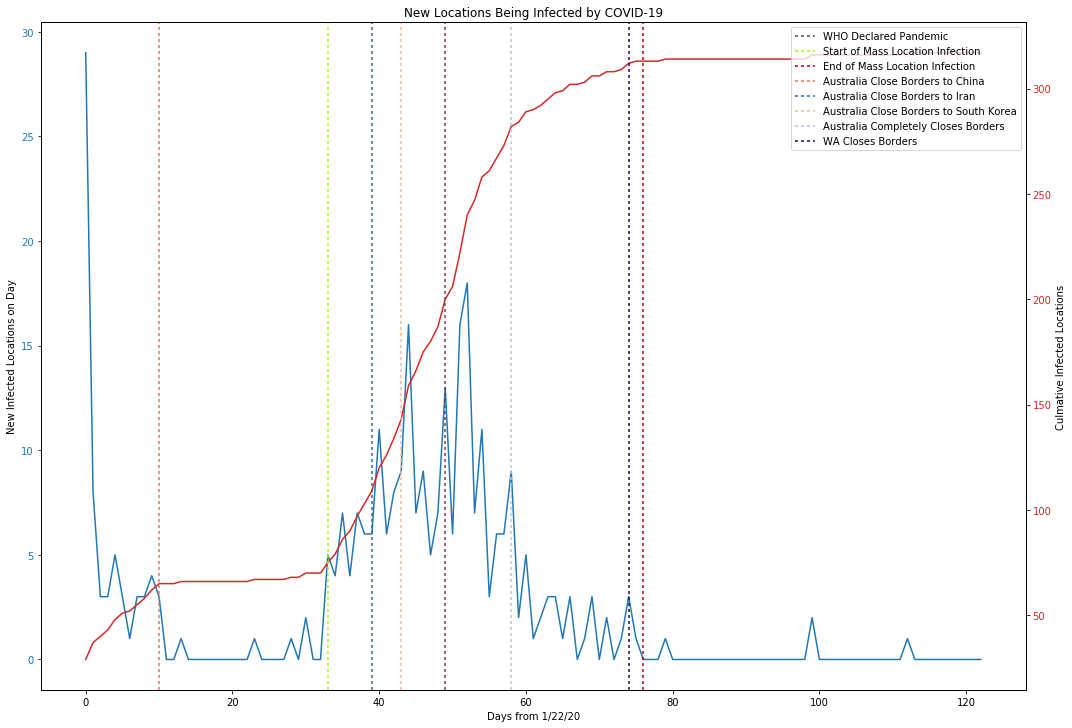

In [10]:
keypoints_timeline = {
    "WHO Declared Pandemic" : "3/11/20",
    "Start of Mass Location Infection" : "2/24/20",
    "End of Mass Location Infection" : "4/7/20",
    "Australia Close Borders to China" : "2/1/20",
    "Australia Close Borders to Iran" : "3/1/20",
    "Australia Close Borders to South Korea" : "3/5/20",
    "Australia Completely Closes Borders" : "3/20/20",
    "WA Closes Borders" : "4/5/20",
}

def plot_new_locations_infected(new_locs, dates, keypoints_timeline,
                                title="New Locations Being Infected by COVID-19"):
    from_day_zero = [day_index for day_index in range(len(dates))]
    new_infections = [len(new_locs[date]) for date in dates]
    new_infections_culm = [new_infections[0]]
    
    for index in range(1, len(new_infections)):
        new_infections_culm.append(new_infections[index] + new_infections_culm[index-1])
    
    fig, ax0 = plt.subplots(figsize=(15,10))
    
    color = 'tab:blue'
    ax0.set_xlabel('Days from 1/22/20')
    ax0.set_ylabel('New Infected Locations on Day')
    ax0.plot(from_day_zero, new_infections, color=color)
    ax0.tick_params(axis='y', labelcolor=color)
    
    ax1 = ax0.twinx()
    
    color = 'tab:red'
    ax1.set_xlabel('Days from 1/22/20')
    ax1.set_ylabel('Culmative Infected Locations')
    ax1.plot(from_day_zero, new_infections_culm, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax0.twinx()
    ax2.get_yaxis().set_visible(False)
    legend_list = []
    for key_event in keypoints_timeline:
        key_event_index = dates.index(keypoints_timeline[key_event])
        ax2.axvline(key_event_index, 0, max(new_infections_culm), 
                    label=key_event, c=np.random.rand(3,), dashes=(2,2))
        legend_list.append(key_event)
    
    ax2.legend(legend_list)
    fig.tight_layout()
    plt.title(title)
    plt.show()
    fig.savefig("./figures/statecountry_new_infections.png", bbox_inches='tight')

dates = get_dates(data_confirmed, bin_region_column)
plot_new_locations_infected(new_locs, dates, keypoints_timeline)

In [11]:
def get_routes_including_loc(node_loc, routes, from_node, bin_region_column):
    node_loc_split = node_loc.split(':')
    
    county_key = "{}County"
    state_key = "{}Province/State"
    country_key = "{}Country/Region"
    
    dir_str = "Arrival"
    if from_node:
        dir_str = "Depart"
    
    county_key = county_key.format(dir_str)
    state_key = state_key.format(dir_str)
    country_key = country_key.format(dir_str)
    
    if bin_region_column == 'county':
        return routes.loc[
            (routes[county_key] == node_loc_split[0]) &
            (routes[state_key] == node_loc_split[1]) &
            (routes[country_key] == node_loc_split[2])
        ]
    elif bin_region_column == 'state':
        return routes.loc[
            (routes[state_key] == node_loc_split[0]) &
            (routes[country_key] == node_loc_split[1])
        ]
    else:
        return routes.loc[
            (routes[country_key] == node_loc_split[0])
        ]

def get_num_routes_from_infect_cluster_to_clean_cluster(infect_graphs, routes, dates, bin_region_column):
    total_infect_to_clean = [0 for ii in range(len(dates))]
    
    def join_to_node_loc_format(row, from_node, bin_region_column):
        county_key = "{}County"
        state_key = "{}Province/State"
        country_key = "{}Country/Region"

        dir_str = "Depart"
        if from_node:
            dir_str = "Arrival"
            
        county_key = county_key.format(dir_str)
        state_key = state_key.format(dir_str)
        country_key = country_key.format(dir_str)
        
        if bin_region_column == 'county':
            return "{}:{}:{}".format(row[county_key], row[state_key], row[country_key])
        elif bin_region_column == 'state':
            return "{}:{}".format(row[state_key], row[country_key])
        else:
            return "{}".format(row[country_key])
    
    for date_index in tqdm(range(len(dates))):
        date = dates[date_index]
        
        infect_graph = infect_graphs[date]
        infected_locations = infect_graph.nodes
        
        for infect_loc in infected_locations:
            from_node = False
            infect_routes = get_routes_including_loc(infect_loc, routes, from_node, bin_region_column)

            for _index, row in infect_routes.iterrows():
                
                other_node_loc = join_to_node_loc_format(row, from_node, bin_region_column)
                if not other_node_loc in infected_locations:
                    total_infect_to_clean[date_index] = total_infect_to_clean[date_index] + 1
                    
            from_node = True
            infect_routes = get_routes_including_loc(infect_loc, routes, from_node, bin_region_column)

            for _index, row in infect_routes.iterrows():
                other_node_loc = join_to_node_loc_format(row, from_node, bin_region_column)
                if not other_node_loc in infected_locations:
                    total_infect_to_clean[date_index] = total_infect_to_clean[date_index] + 1
    
    return total_infect_to_clean
                
        

In [12]:
total_infect_to_clean = get_num_routes_from_infect_cluster_to_clean_cluster(infect_graphs, 
                                                                            routes, 
                                                                            dates, 
                                                                            bin_region_column)

100%|██████████| 123/123 [03:30<00:00,  1.71s/it]


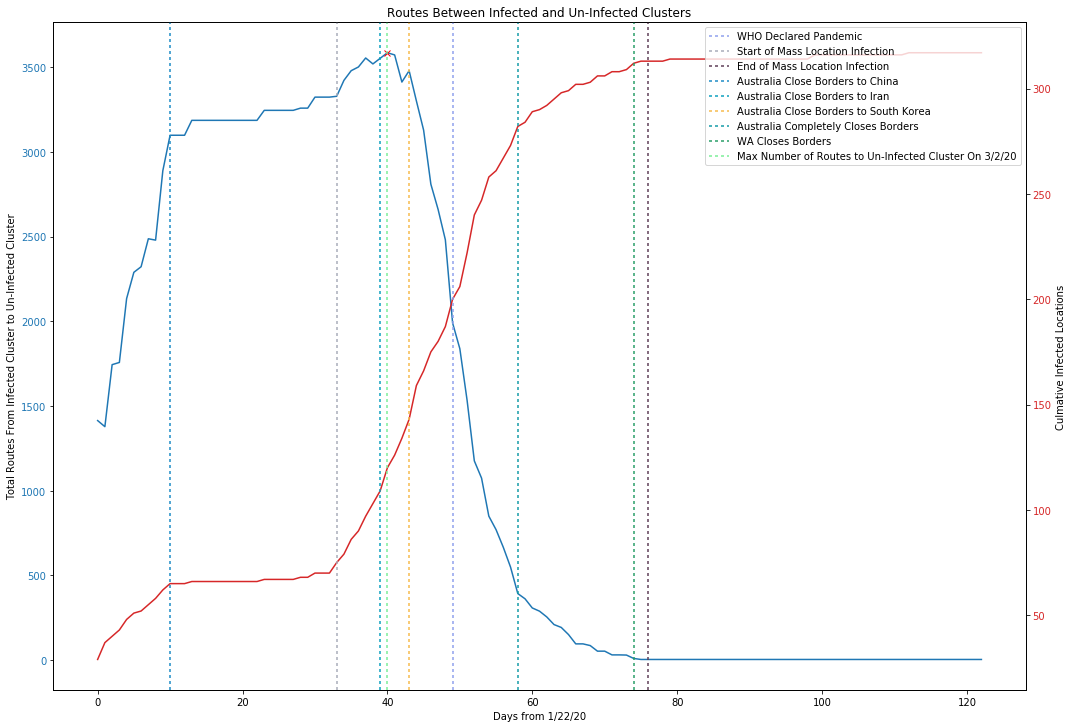

In [13]:
def plot_total_paths_from_infect_cluster(new_locs, total_infect_to_clean, dates, keypoints_timeline,
                                         title="Routes Between Infected and Un-Infected Clusters"):
    from_day_zero = [day_index for day_index in range(len(dates))]
    new_infections = [len(new_locs[date]) for date in dates]
    new_infections_culm = [new_infections[0]]
    
    for index in range(1, len(new_infections)):
        new_infections_culm.append(new_infections[index] + new_infections_culm[index-1])
    
    fig, ax0 = plt.subplots(figsize=(15,10))
    
    color = 'tab:blue'
    ax0.set_xlabel('Days from 1/22/20')
    ax0.set_ylabel('Total Routes From Infected Cluster to Un-Infected Cluster')
    ax0.plot(from_day_zero, total_infect_to_clean, color=color)
    ax0.tick_params(axis='y', labelcolor=color)
    
    ax1 = ax0.twinx()
    
    color = 'tab:red'
    ax1.set_xlabel('Days from 1/22/20')
    ax1.set_ylabel('Culmative Infected Locations')
    ax1.plot(from_day_zero, new_infections_culm, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax0.twinx()
    ax2.get_yaxis().set_visible(False)
    legend_list = []
    for key_event in keypoints_timeline:
        key_event_index = dates.index(keypoints_timeline[key_event])
        ax2.axvline(key_event_index, 0, max(new_infections_culm), 
                    label=key_event, c=np.random.rand(3,), dashes=(2,2))
        legend_list.append(key_event)
        
    max_total_paths = max(total_infect_to_clean)
    max_total_paths_index = total_infect_to_clean.index(max_total_paths)
    
    crit_label = 'Max Number of Routes to Un-Infected Cluster On {}'.format(dates[max_total_paths_index])
    ax0.plot(max_total_paths_index, max_total_paths, 'rx')
    ax2.axvline(max_total_paths_index, 0, max(new_infections_culm),
                label=crit_label, c=np.random.rand(3,), dashes=(2,2))
    legend_list.append(crit_label)
    
    ax2.legend(legend_list)
    fig.tight_layout()
    plt.title(title)
    plt.show()
    fig.savefig("./figures/statecountry_cluster_paths.png", bbox_inches='tight')
    
plot_total_paths_from_infect_cluster(new_locs, total_infect_to_clean, dates, keypoints_timeline)

In [16]:
infect_thresh = get_initial_infect_thresh(data_confirmed, 0.20)
if infect_thresh <= 0: infect_thresh = 1
print("INITIAL INFECTION THRESHOLD SET TO {}".format(infect_thresh))
infect_graphs_top_20, location_pos_top_20, max_confirmed_top_20, infected_parents_top_20, new_locs_top_20, new_edges_top_20 = get_infection_path(data_confirmed, 
                                                                                                                                                 routes, 
                                                                                                                                                 infect_thresh, 
                                                                                                                                                 bin_region_column,
                                                                                                                                                 border_closures=border_closures)

animation_top_20_percent = TimeMapAnimation(infect_graphs_top_20, 
                                            location_pos_top_20, 
                                            data_confirmed, 
                                            routes, 
                                            new_locs_top_20, 
                                            new_edges_top_20,
                                            bin_region_column,
                                            period=0.1,
                                           )
animation_top_20_percent.displayMap()

 46%|████▌     | 56/123 [00:00<00:00, 529.23it/s]

INITIAL INFECTION THRESHOLD SET TO 16053.0


100%|██████████| 123/123 [00:09<00:00, 13.04it/s]


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [17]:
animation_top_20_percent.startAnimation()

In [8]:
len(infect_graphs['5/23/20'].edges)

5358

In [111]:
len(infect_graphs['5/23/20'].edges)

5175

In [118]:
new_edges_top_20

{'1/22/20': [],
 '1/23/20': [],
 '1/24/20': [],
 '1/25/20': [],
 '1/26/20': [],
 '1/27/20': [],
 '1/28/20': [],
 '1/29/20': [],
 '1/30/20': [],
 '1/31/20': [],
 '2/1/20': [],
 '2/2/20': [],
 '2/3/20': [],
 '2/4/20': [],
 '2/5/20': [],
 '2/6/20': [],
 '2/7/20': [],
 '2/8/20': [],
 '2/9/20': [],
 '2/10/20': [],
 '2/11/20': [],
 '2/12/20': [],
 '2/13/20': [],
 '2/14/20': [],
 '2/15/20': [],
 '2/16/20': [],
 '2/17/20': [],
 '2/18/20': [],
 '2/19/20': [],
 '2/20/20': [],
 '2/21/20': [],
 '2/22/20': [],
 '2/23/20': [],
 '2/24/20': [],
 '2/25/20': [],
 '2/26/20': [],
 '2/27/20': [],
 '2/28/20': [],
 '2/29/20': [],
 '3/1/20': [],
 '3/2/20': [],
 '3/3/20': [],
 '3/4/20': [],
 '3/5/20': [],
 '3/6/20': [],
 '3/7/20': [],
 '3/8/20': [],
 '3/9/20': [],
 '3/10/20': [],
 '3/11/20': [],
 '3/12/20': [],
 '3/13/20': [('Hubei:China', 'none:Italy')],
 '3/14/20': [],
 '3/15/20': [],
 '3/16/20': [],
 '3/17/20': [('none:Italy', 'none:Iran')],
 '3/18/20': [],
 '3/19/20': [('none:Italy', 'none:Spain'), ('none: